## Project: Cell body segmentation prediction using machine learning
- **Source**: Hill, LaPan, Li and Haney (2007). Impact of image segmentation on high-content screening data quality for SK-BR-3 cells, BMC Bioinformatics, Vol. 8, pg. 340
- **Date**: 10/01/24
- **Goal**: Create a basic prediction model and a feature explainer

In [1]:
# Step 0. Import libraries, custom modules and logging
# Basics ---------------------------------------------------------------
import logging
import joblib
# Data -----------------------------------------------------------------
import pandas as pd
import numpy as np
# Graphics -------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
# Machine learning -----------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, 
                             f1_score,
                             classification_report,
                             ConfusionMatrixDisplay,
                             RocCurveDisplay,
                             DetCurveDisplay)
from sklearn.tree import plot_tree
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import (PowerTransformer,
                                   LabelEncoder)
from sklearn.utils import resample
# Logging initialization -----------------------------------------------
logger = logging.getLogger()
logger.setLevel(logging.INFO)

### 1. Data loading
**Objective**: Obtain the data from source and get a first glimpse of their properties and presentation

In [2]:
# Step 1. Load data and wrangle ----------------------------------
# 1.1 Read from source and get basic info
df_raw = pd.read_csv('skbr_cells.csv')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2019 entries, 0 to 2018
Data columns (total 61 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Cell                     2019 non-null   int64  
 1   Case                     2019 non-null   object 
 2   Class                    2019 non-null   object 
 3   AngleCh1                 2019 non-null   float64
 4   AreaCh1                  2019 non-null   int64  
 5   AvgIntenCh1              2019 non-null   float64
 6   AvgIntenCh2              2019 non-null   float64
 7   AvgIntenCh3              2019 non-null   float64
 8   AvgIntenCh4              2019 non-null   float64
 9   ConvexHullAreaRatioCh1   2019 non-null   float64
 10  ConvexHullPerimRatioCh1  2019 non-null   float64
 11  DiffIntenDensityCh1      2019 non-null   float64
 12  DiffIntenDensityCh3      2019 non-null   float64
 13  DiffIntenDensityCh4      2019 non-null   float64
 14  EntropyIntenCh1         

In [3]:
# 1.2 Get a sample
display(df_raw.sample(10, random_state=2024))

,Cell,Case,Class,AngleCh1,AreaCh1,AvgIntenCh1,AvgIntenCh2,AvgIntenCh3,AvgIntenCh4,ConvexHullAreaRatioCh1,...,TotalIntenCh1,TotalIntenCh2,TotalIntenCh3,TotalIntenCh4,VarIntenCh1,VarIntenCh3,VarIntenCh4,WidthCh1,XCentroid,YCentroid
1781,208412526,Train,PS,104.208986,372,52.304225,114.822535,38.219718,58.383099,1.197572,...,18568,40408,13568,20726,33.307494,37.597455,49.828379,15.956169,81,277
856,208340336,Train,PS,47.697886,155,77.885135,74.864865,181.189189,180.020270,1.210777,...,11527,10933,26816,26643,61.789587,180.934039,156.294311,13.289130,316,136
1281,208322195,Test,PS,79.971064,393,46.592000,169.530667,88.418667,69.330667,1.364899,...,17472,63200,33157,25999,39.645179,79.688849,68.986743,20.053071,423,228
1878,208332514,Test,PS,57.764663,202,38.015544,4.823834,83.751295,8.056995,1.339736,...,7337,739,16164,1555,25.612796,53.556327,19.686977,11.975392,328,55
1013,208405198,Test,PS,61.292430,380,104.787879,247.005510,50.143251,56.165289,1.236340,...,38038,89301,18202,20388,59.918187,73.120312,72.884340,17.981055,62,172
128,208384284,Test,PS,16.587410,212,22.103448,2.113300,44.640394,83.610837,1.232394,...,4487,227,9062,16973,16.705037,23.722196,53.352913,14.008268,70,76
133,208402927,Test,PS,48.768215,277,35.267925,60.086792,82.483019,34.471698,1.451296,...,9346,15659,21858,9135,28.352497,67.968366,52.255109,23.600570,438,136
650,208332444,Train,WS,129.876395,162,17.374194,61.761290,22.664516,61.154839,1.102719,...,2693,9419,3513,9479,15.580446,28.853641,55.956336,11.397614,355,17
206,208320986,Test,WS,108.508951,309,85.894915,145.813559,121.725424,16.301695,1.240323,...,25339,42721,35909,4809,56.524413,186.966060,22.175582,17.154507,130,77
1495,208405392,Train,WS,66.827049,414,61.134177,259.030380,87.807595,190.098734,1.089681,...,24148,101923,34684,75089,45.452713,108.516269,155.754230,21.776303,364,362


### 2. Data preprocessing
**Objectives**: Perform the data cleaning, data transformation and data reduction steps to avoid data mistmatching, noisy data or data not wrangled

In [4]:
# Step 2. Prepara the dataset for analysis
# 2.1 Make transformations using a pipeline
df_interim = (
    df_raw
    .copy()
    .set_axis(
        df_raw.columns.str.replace(' ','_')
        .str.replace(r'\W','',regex=True)
        .str.lower()
        .str.slice(0,40), axis=1
    )
    .loc[:,['perimch1','eqsphereareach1','entropyintench1','class']]
    .drop_duplicates()
    .rename(columns={'class':'target'})
    .astype({'target':'category'})
)

In [5]:
# 2.2 Create the final dataset with the target in front
df = (
    df_interim
    .copy()
    .reindex(
        columns=(
            ['target'] + 
            [c for c in df_interim.columns.to_list() if c not in ['target']]
        )
    )
)

### 3. Exploratory Data Analysis
**Objective**: Summarize the main characteristics of the dataset using descriptive statistics and data visualization methods

In [6]:
# Step 3. Perform EDA
# 3.1 Split the dataset
df_train, df_test = train_test_split(df, 
                                     random_state=2024, 
                                     test_size=0.20, 
                                     stratify=df['target'])
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1615 entries, 1671 to 321
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   target           1615 non-null   category
 1   perimch1         1615 non-null   float64 
 2   eqsphereareach1  1615 non-null   float64 
 3   entropyintench1  1615 non-null   float64 
dtypes: category(1), float64(3)
memory usage: 52.2 KB


In [7]:
power_transformer = PowerTransformer()
X_train = power_transformer.fit_transform(df_train.drop('target',axis=1))
X_test = power_transformer.transform(df_test.drop('target',axis=1))
df_train_tf = pd.DataFrame(X_train, columns=df_train.drop('target',axis=1).columns).reset_index(drop=True)
df_test_tf = pd.DataFrame(X_test, columns=df_test.drop('target',axis=1).columns).reset_index(drop=True)
df_train_tf['target'] = df_train['target'].values
df_test_tf['target'] = df_test['target'].values
df_train = df_train_tf
df_test = df_test_tf

In [8]:
power_transformer.lambdas_

array([-1.16995456, -0.91474706, -0.30201944])

In [9]:
# 3.1 Get numerical and categorical summaries
display(df_train.describe(include='number').T)
display(df_train.describe(include='category').T)

,count,mean,std,min,25%,50%,75%,max
perimch1,1615.0,3.112419e-14,1.00031,-2.278852,-0.744494,-0.037161,0.711497,2.474413
eqsphereareach1,1615.0,2.393165e-13,1.00031,-1.765610,-0.813263,-0.008468,0.752210,2.406261
entropyintench1,1615.0,1.624569e-15,1.00031,-2.924521,-0.711637,0.061764,0.668714,3.161730


,count,unique,top,freq
target,1615,2,PS,1040


In [10]:
# 3.1 Get details of response variable
table = pd.concat(
    [df_train['target'].value_counts(),
     df_train['target'].value_counts(normalize=True)],axis=1
)
display(table)
print(f'Sum:{df_train['target'].count()}')

,count,proportion
target,,
PS,1040,0.643963
WS,575,0.356037


Sum:1615


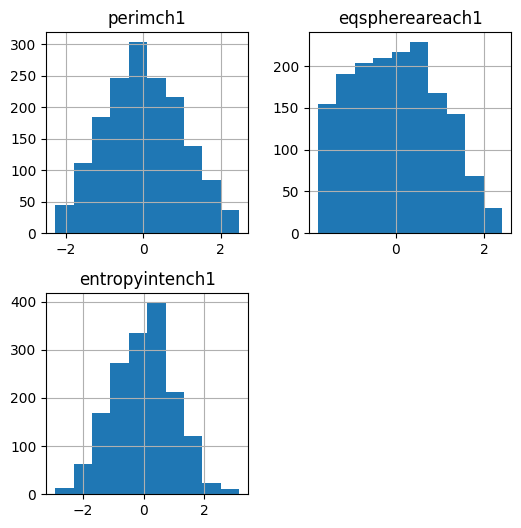

In [11]:
# 2.2 Perform univariate analysis on numerical variables
df_train.hist(figsize=(6,6))
plt.show()

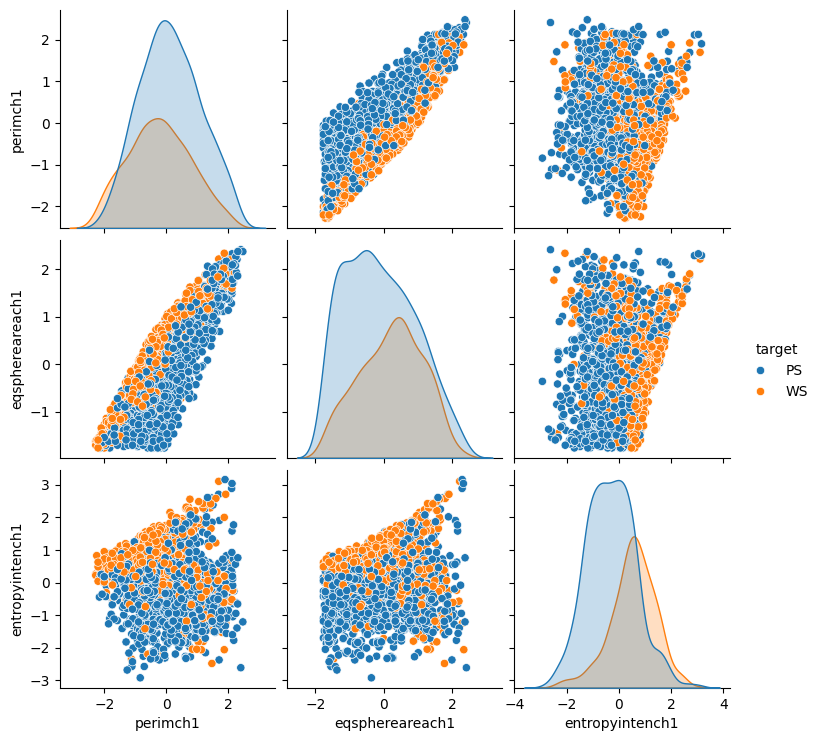

In [12]:
# 2.4 Perform bivariate analysis for numerical values, using target
sns.pairplot(data=df_train, hue='target')
plt.show()

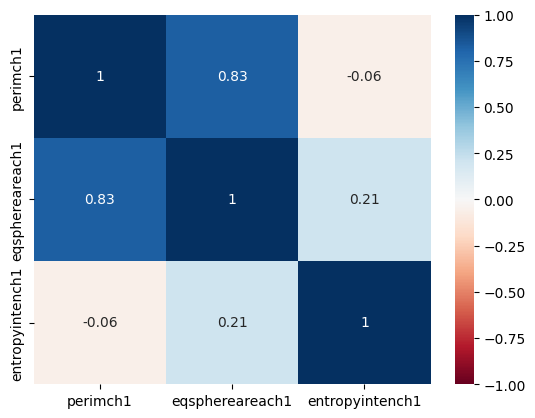

In [13]:
# 2.6 Perform correlation analysis
sns.heatmap(data=df_train.select_dtypes('number').corr(), vmin=-1, vmax=1, cmap='RdBu', annot=True)
plt.show()

### 4. Machine learning
**Objective**: Create a model that learns from data to make predictions and generalize to unseen data, and thus perform tasks without explicit instructions

In [14]:
# Step 4. Create a machine learning model
# 4.1 Split features and reponse
X_train = df_train.drop('target', axis=1).reset_index(drop=True)
y_train = df_train['target'].reset_index(drop=True)
X_test = df_test.drop('target', axis=1).reset_index(drop=True)
y_test = df_test['target'].reset_index(drop=True)

In [15]:
# 4.2 Encode the response 
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)

In [16]:
# 4.5 Train the model 
clf_tree = DecisionTreeClassifier(class_weight='balanced', max_depth=3)
clf_tree.fit(X_train, y_train_enc)

DecisionTreeClassifier(class_weight='balanced', max_depth=3)

Accuracy: 0.728
F1 Score: 0.650
              precision    recall  f1-score   support

          PS       0.82      0.74      0.78       260
          WS       0.60      0.71      0.65       144

    accuracy                           0.73       404
   macro avg       0.71      0.72      0.71       404
weighted avg       0.74      0.73      0.73       404



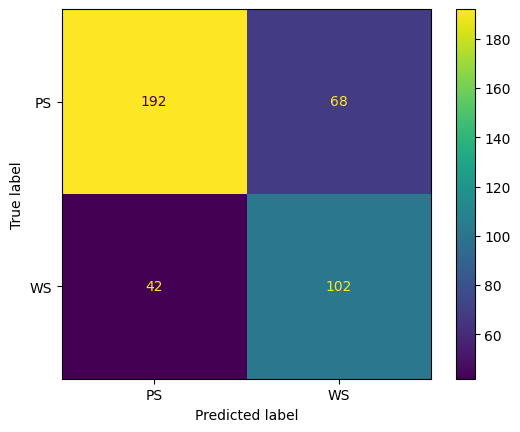

In [17]:
# 4.6 Predict on test data and get accuracy and confusion matrix
y_hat = clf_tree.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test_enc, y_hat):.3f}')
print(f'F1 Score: {f1_score(y_test_enc, y_hat):.3f}')
print(classification_report(y_test_enc, y_hat, target_names=label_encoder.classes_))
ConfusionMatrixDisplay.from_predictions(y_test_enc, y_hat, display_labels=label_encoder.classes_)
plt.show()

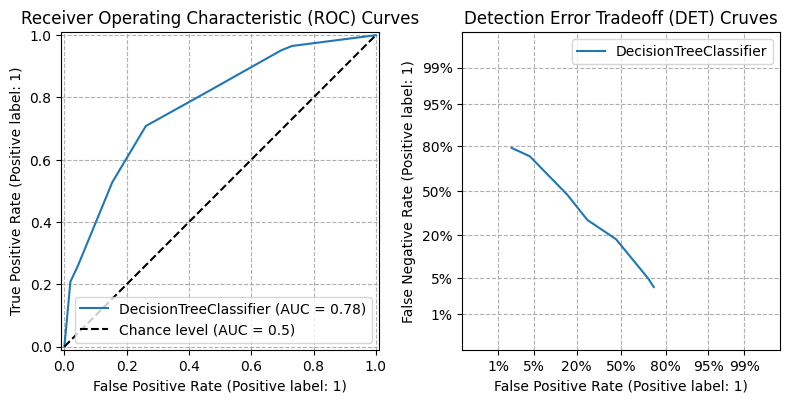

In [18]:
# 4.7 Visualize the probabilities of scores of the classifier
fig, [ax_roc, ax_det] = plt.subplots(1,2, figsize=(8,8))
RocCurveDisplay.from_estimator(
    clf_tree, X_test, y_test_enc, ax=ax_roc, plot_chance_level=True
)
DetCurveDisplay.from_estimator(
    clf_tree, X_test, y_test_enc, ax=ax_det
)
ax_roc.set_title("Receiver Operating Characteristic (ROC) Curves")
ax_det.set_title("Detection Error Tradeoff (DET) Cruves")
ax_roc.grid(linestyle='--')
ax_det.grid(linestyle='--')
ax_det.set_aspect('equal')
plt.legend()
plt.tight_layout()
plt.show()

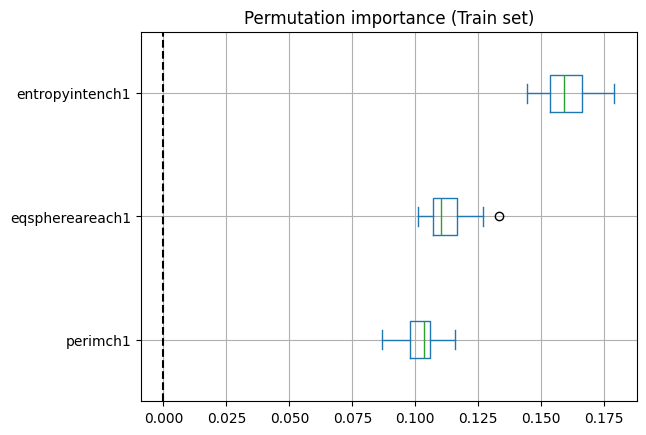

In [19]:
# 4.8 Evaluate the importance of the variables in predicting an outcome
importance = permutation_importance(clf_tree, X_train, y_train_enc, n_repeats=25, random_state=2024)
importance_df = pd.DataFrame(importance.importances.T, columns=X_train.columns)
ax = importance_df.plot.box(vert=False)
ax.axvline(x=0, color='k', linestyle='--')
ax.set_title('Permutation importance (Train set)')
ax.grid(True)
plt.show()

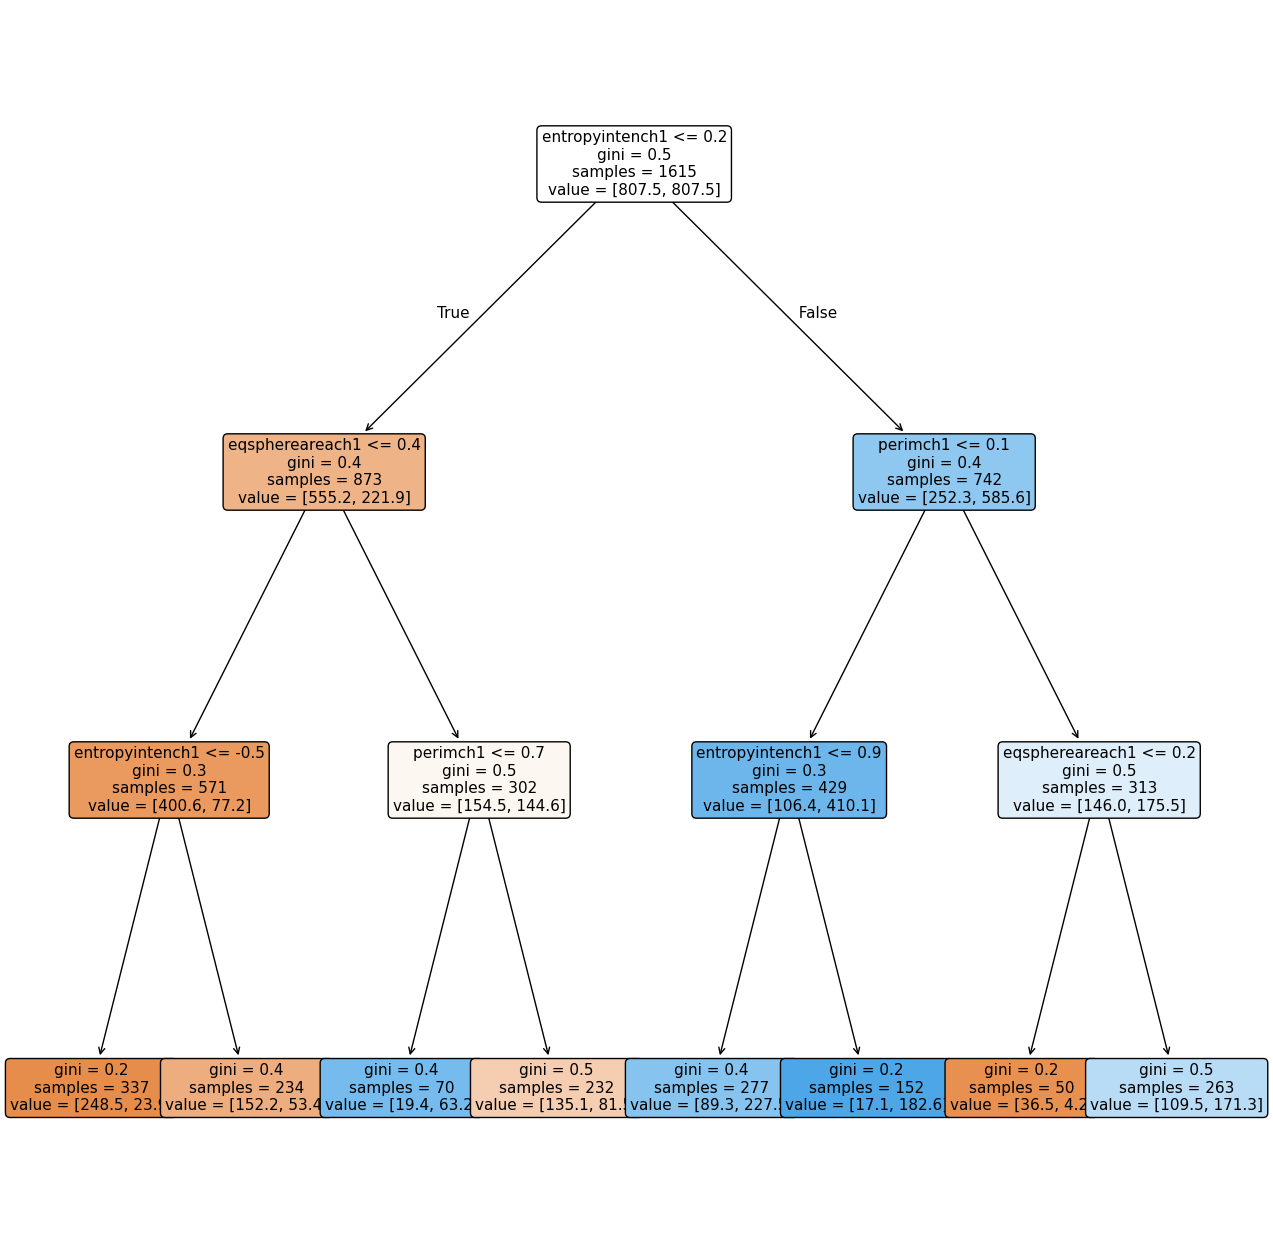

In [20]:
plt.figure(figsize=(16,16))
plot_tree(clf_tree, filled=True, fontsize=11, feature_names=X_train.columns, rounded=True, precision=1)
plt.show()

In [21]:
clf_lgr = LogisticRegression()
clf_lgr.fit(X_train, y_train_enc)

LogisticRegression()

Accuracy: 0.812
F1 Score: 0.705
              precision    recall  f1-score   support

          PS       0.82      0.91      0.86       260
          WS       0.80      0.63      0.71       144

    accuracy                           0.81       404
   macro avg       0.81      0.77      0.78       404
weighted avg       0.81      0.81      0.81       404



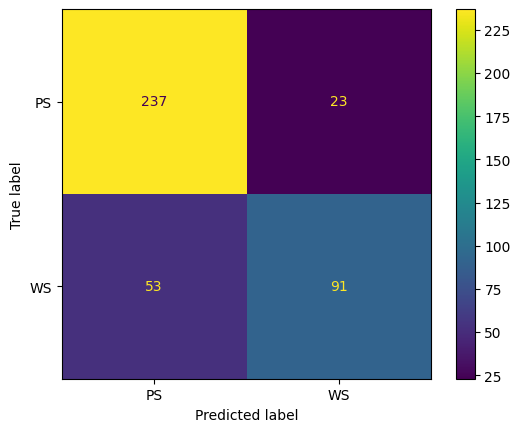

In [ ]:
# 4.6 Predict on test data and get accuracy and confusion matrix
y_hat_lgr = clf_lgr.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test_enc, y_hat_lgr):.3f}')
print(f'F1 Score: {f1_score(y_test_enc, y_hat_lgr):.3f}')
print(classification_report(y_test_enc, y_hat_lgr, target_names=label_encoder.classes_))
ConfusionMatrixDisplay.from_predictions(y_test_enc, y_hat_lgr, display_labels=label_encoder.classes_)
plt.show()

In [23]:
clf_gbc = GradientBoostingClassifier()
clf_gbc.fit(X_train, y_train_enc)

GradientBoostingClassifier()

Accuracy: 0.795
F1 Score: 0.687
              precision    recall  f1-score   support

          PS       0.81      0.88      0.85       260
          WS       0.75      0.63      0.69       144

    accuracy                           0.79       404
   macro avg       0.78      0.76      0.77       404
weighted avg       0.79      0.79      0.79       404



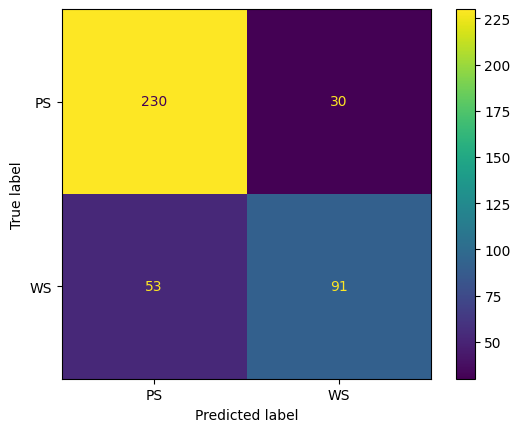

In [ ]:
# 4.6 Predict on test data and get accuracy and confusion matrix
y_hat_gbc = clf_gbc.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test_enc, y_hat_gbc):.3f}')
print(f'F1 Score: {f1_score(y_test_enc, y_hat_gbc):.3f}')
print(classification_report(y_test_enc, y_hat_gbc, target_names=label_encoder.classes_))
ConfusionMatrixDisplay.from_predictions(y_test_enc, y_hat_gbc, display_labels=label_encoder.classes_)
plt.show()

### 5. Model saving
**Objective**: Save the model and some critical information we consider necessary

In [25]:
# Step 5. Save the model for further usage
# 5.1 Create model dictionary
model_dict = {
    'model': clf_tree,
    'predictors': X_train.columns.to_list(),
    'target_name': y_train.name,
    'algorithm_name': 'Logistic regression'
}

In [26]:
# 5.2 Save the model dictionary
try:
    joblib.dump(model_dict, 'titanic_model_dict.joblib')
    logger.info("Save succesful")
except Exception as e:
    logger.error(f"An error occurred: {e}")

### 6. Notes
**Objective**: Add some comments or experiments done on experimenting